## Load dataset

In [14]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, roc_auc_score


# Load the 'ring' datasets
train_separable = pd.read_csv('../../input/A2-ring/A2-ring-separable.txt', sep="\t", header=None)
train_merged = pd.read_csv('../../input/A2-ring/A2-ring-merged.txt', sep="\t", header=None)
test = pd.read_csv('../../input/A2-ring/A2-ring-test.txt', sep="\t", header=None)

# Define column names
columns = ['Feature1', 'Feature2', 'Class']

# Assign column names to the datasets
train_separable.columns, train_merged.columns, test.columns = columns, columns, columns

# Separate features and labels
X_train_sep = train_separable.iloc[:, :-1]
y_train_sep = train_separable.iloc[:, -1]
X_train_mrg = train_merged.iloc[:, :-1]
y_train_mrg = train_merged.iloc[:, -1]
X_test = test.iloc[:, :-1]
y_test = test.iloc[:, -1]




## MLR algorithm

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, roc_auc_score
import numpy as np

# Function to apply MLR and evaluate the model
def mlr(X_train, y_train, X_test, y_test, dataset_name):
    # Set up and train the linear regression model
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)

    # Predict outcomes for the test dataset
    predicted_values = linear_model.predict(X_test)

    # Decide a cutoff point to classify predictions as 0 or 1
    cutoff_threshold = 0.5
    predicted_classes = (predicted_values > cutoff_threshold).astype(int)

    # Calculate the accuracy of the model
    model_accuracy = np.mean(predicted_classes.ravel() == y_test.values.ravel())
    print(f"\nMLR Model - {dataset_name} Data")
    print("Accuracy: ", model_accuracy)

    # Show the confusion matrix and ROC AUC score
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, predicted_classes))
    print("ROC AUC Score: ", roc_auc_score(y_test, predicted_classes))

    # Calculate and display the classification error
    classification_error = 1 - model_accuracy
    print("Classification Error on Test Set:", classification_error)

# Apply MLR to the separable dataset
mlr(X_train_sep, y_train_sep, X_test, y_test, "Separable")

# Apply MLR to the merged dataset
mlr(X_train_mrg, y_train_mrg, X_test, y_test, "Merged")



MLR Model - Separable Data
Accuracy:  0.5289
Confusion Matrix:
[[5289   44]
 [4667    0]]
ROC AUC Score:  0.4958747421713857
Classification Error on Test Set: 0.47109999999999996

MLR Model - Merged Data
Accuracy:  0.5333
Confusion Matrix:
[[5333    0]
 [4667    0]]
ROC AUC Score:  0.5
Classification Error on Test Set: 0.4667


## Cross-validation and parameter turning

In [16]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression

# Define the MLRClassifier
class MLRClassifier:
    def __init__(self, threshold=0.5):
        self.regressor = LinearRegression()
        self.threshold = threshold

    def fit(self, X, y):
        self.regressor.fit(X, y)
    
    def predict(self, X):
        predictions = self.regressor.predict(X)
        return (predictions > self.threshold).astype(int)
    
    def get_params(self, deep=True):
        return {"threshold": self.threshold}

    def set_params(self, **parameters):
        for param, value in parameters.items():
            setattr(self, param, value)
        return self

# Custom scoring function for accuracy
def calculate_accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

# Function to perform cross-validation and parameter tuning
def cross_validate_and_tune(X_train, y_train, dataset_name):
    cross_validation = KFold(n_splits=5)
    data_processing_pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Initial scaler, will be tuned
        ('regressor', MLRClassifier())
    ])
    accuracy_scoring = make_scorer(calculate_accuracy)
    parameter_grid = {
        'scaler': [StandardScaler(), MinMaxScaler()],
        'regressor__threshold': [0.4, 0.5, 0.6],
    }
    parameter_search = GridSearchCV(data_processing_pipeline, parameter_grid, cv=cross_validation, scoring=accuracy_scoring)
    parameter_search.fit(X_train, y_train)

    print(f"\nOptimal parameters for {dataset_name} Dataset:")
    print("Best Parameters:", parameter_search.best_params_)
    print("Best Cross-validation Score:", parameter_search.best_score_)

    mean_classification_error = 1 - parameter_search.best_score_
    print("Mean Classification Error in Cross-Validation:", mean_classification_error)

    return parameter_search.best_estimator_


# Perform cross-validation and parameter tuning for both dataset
best_model_sep = cross_validate_and_tune(X_train_sep, y_train_sep, "Separable")
best_model_mrg = cross_validate_and_tune(X_train_mrg, y_train_mrg, "Merged")



Optimal parameters for Separable Dataset:
Best Parameters: {'regressor__threshold': 0.6, 'scaler': StandardScaler()}
Best Cross-validation Score: 0.5203
Mean Classification Error in Cross-Validation: 0.4797

Optimal parameters for Merged Dataset:
Best Parameters: {'regressor__threshold': 0.5, 'scaler': StandardScaler()}
Best Cross-validation Score: 0.5515
Mean Classification Error in Cross-Validation: 0.4485


## ROC curve and AUC


Optimal parameters for Separable Dataset:
Best Parameters: {'regressor__threshold': 0.6, 'scaler': StandardScaler()}
Best Cross-validation Score: 0.5203
Mean Classification Error in Cross-Validation: 0.4797

Optimal parameters for Merged Dataset:
Best Parameters: {'regressor__threshold': 0.5, 'scaler': StandardScaler()}
Best Cross-validation Score: 0.5515
Mean Classification Error in Cross-Validation: 0.4485

Separable Dataset - MLR ROC Curve and AUC


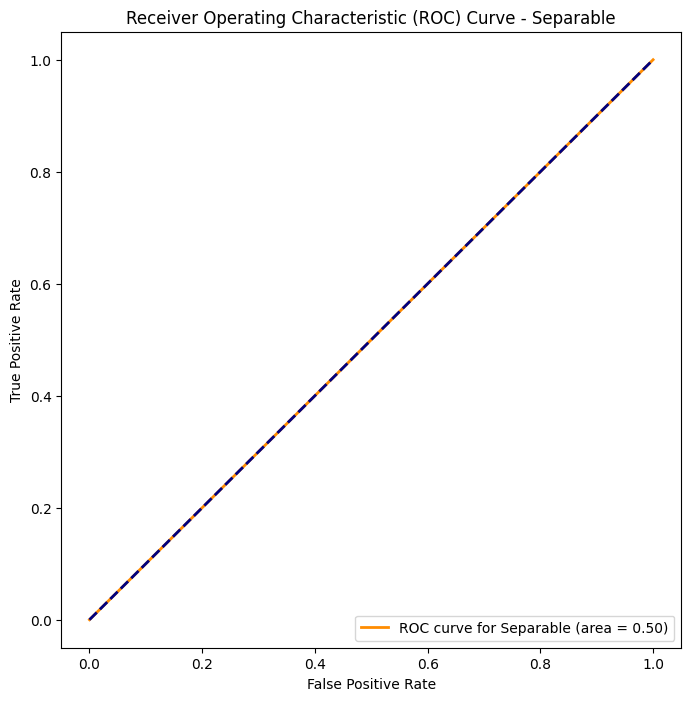


Merged Dataset - MLR ROC Curve and AUC


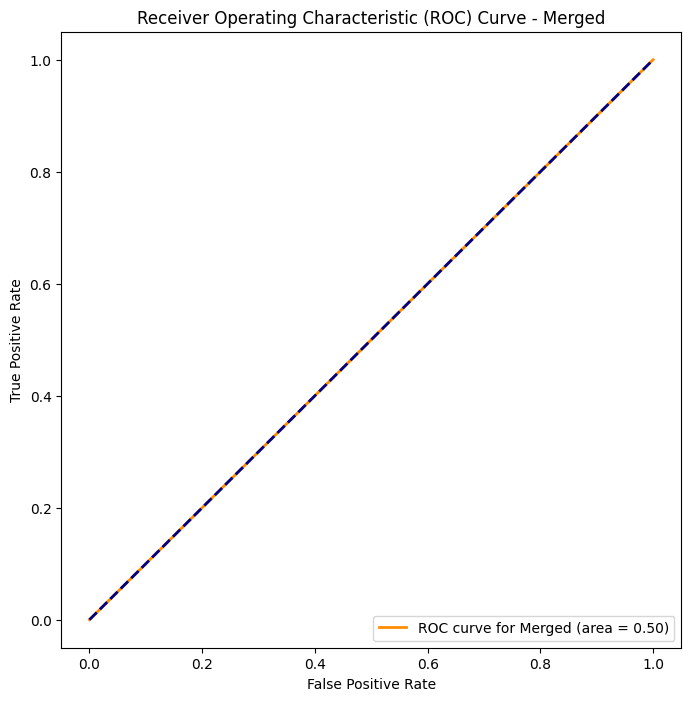

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Function to plot ROC curve
def plot_roc(model, X_test, y_test, dataset_name):
    # Ensure the model is trained
    model.fit(X_test, y_test)

    # Get the continuous outputs for ROC calculation
    y_prob = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot for the ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve for {dataset_name} (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {dataset_name}')
    plt.legend(loc="lower right")
    plt.show()

# Run Grid Search and Parameter Tuning
best_model_sep = cross_validate_and_tune(X_train_sep, y_train_sep, "Separable")
best_model_mrg = cross_validate_and_tune(X_train_mrg, y_train_mrg, "Merged")

if best_model_sep is None or best_model_mrg is None:
    raise ValueError("Model training failed, one of the models is None")

print("\nSeparable Dataset - MLR ROC Curve and AUC")
plot_roc(best_model_sep, X_test, y_test, "Separable")

print("\nMerged Dataset - MLR ROC Curve and AUC")
plot_roc(best_model_mrg, X_test, y_test, "Merged")


